In [1]:
import numpy as np

import cycler
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D

import pygam
from sklearn.linear_model import RidgeCV
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


from LookaheadCQR.lookahead.models.lookahead import Lookahead
import LookaheadCQR.lookahead.models.uncertainty as uncert
import LookaheadCQR.lookahead.models.prediction as pred
import LookaheadCQR.lookahead.models.propensity as prop
from LookaheadCQR.cqr_lookahead.uncertainty import CQR

%matplotlib inline
np.set_printoptions(precision=3)

## Loading the diabetes dataset

In [2]:
#load data
data_bunch = load_diabetes()
x,y0 = data = load_diabetes(return_X_y=True)
y0 = -y0
y0 = (y0-np.min(y0))/(np.max(y0)-np.min(y0))
scaler = StandardScaler()
scaler.fit(x)
scaler.transform(x, copy=False)
n = x.shape[0]
d = x.shape[1]

## Defining the groundtruth model.
Here we choose linearGAM model as f*

In [3]:
lams = np.random.rand(100, x.shape[1])
lams = lams * 6 - 3
lams = np.exp(lams)
fstar = pygam.LinearGAM(n_splines=12, max_iter=100).gridsearch(x, y0, lam=lams)
y = fstar.predict(x)
mse_star = np.mean(np.square(y-y0))
mae_star = np.mean(np.abs(y-y0))
print("[f*] mse(y,y0):", mse_star)
print("[f*] mae(y,y0):", mae_star)

100% (100 of 100) |######################| Elapsed Time: 0:00:19 Time:  0:00:19


[f*] mse(y,y0): 0.024224088138794043
[f*] mae(y,y0): 0.12555066663774114


<Figure size 432x288 with 0 Axes>

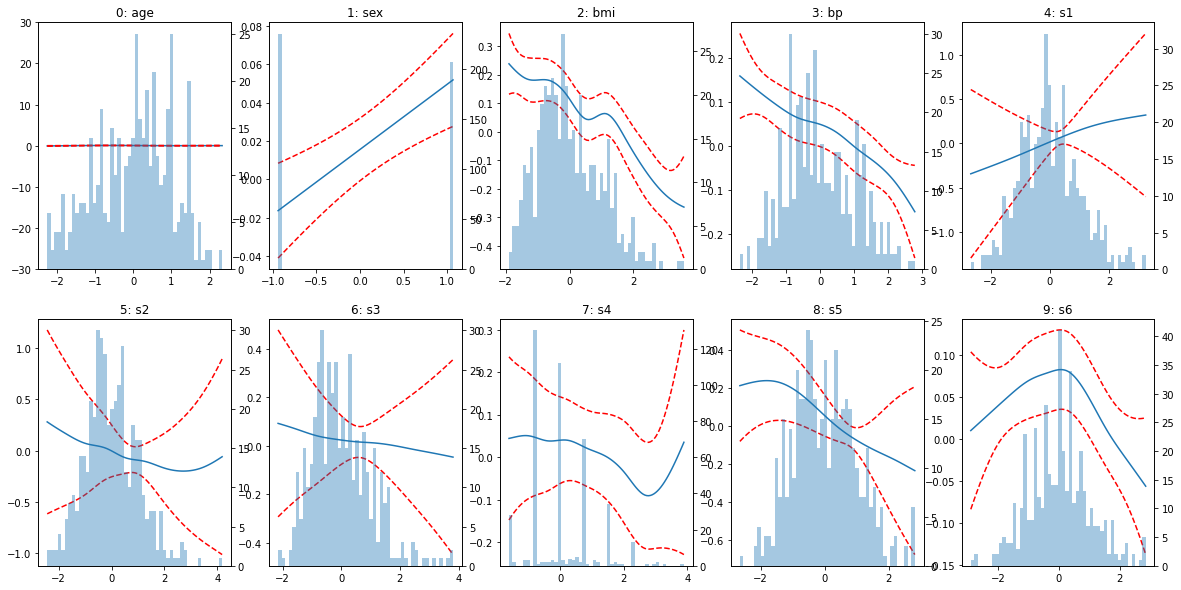

In [4]:
titles = data_bunch.feature_names
titles_idx = [str(i)+': '+titles[i] for i in range(len(titles))]

plt.figure()
fig, axs = plt.subplots(2,5,figsize=(20, 10))
for i, ax in enumerate(axs.flatten()[:x.shape[1]]):
    XX = fstar.generate_X_grid(term=i)
    ax.plot(XX[:, i], fstar.partial_dependence(term=i, X=XX))
    ax2 = ax.twinx()
    ax2.hist(x[:, i], alpha=.4, bins=50) #, density=True)
    ax.plot(XX[:, i], fstar.partial_dependence(term=i, X=XX,   width=.95)[1], c='r', ls='--')
    if i == 0:
        ax.set_ylim(-30,30)
    ax.set_title(titles_idx[i])
plt.show()

## Generating the train-test splits

In [5]:
# split data
seed = 1
trn_sz = 0.75 # working-set relative size
active = np.arange(n) # No sub-sampling

x_active = x[active,:]
# y_active = y[active]
y_active = y0[active]
n_active = y_active.shape[0]

x_trn, x_tst, y_trn, y_tst, idx_trn, idx_tst = train_test_split(x_active, y_active, active, test_size=1-trn_sz, random_state=seed)
n_trn, n_tst = (x_trn.shape[0], x_tst.shape[0])
print('n:', n, ', n_active:', n_active, ", n_trn:", n_trn, ", n_tst:", n_tst)

xs = [x_trn, x_tst, x_active, x]
ys = [y_trn, y_tst, y_active, y]

n: 442 , n_active: 442 , n_trn: 331 , n_tst: 111


## Setting the hyperparamters of the look ahead model

In [6]:
# Step Size
eta = 5.

# L2 regularization coefficients
alphas = np.hstack([1e-5, 2.**np.arange(-8,6,1)])
alphas_sub = [0, 0.125, 0.25, 0.5, 1.0, 2.0, 4.0, 8.0]

# Lookahead regularization coefficient
lams = np.hstack([1e-5, 2.**np.arange(-7,-1,1)]) #lookahead penalty coefficients

# Setting features that can by altered using mask
# Features - 2 and 4 are the only non-immutable features
mask = np.zeros(d)
mask[[2,4]] = 1

# Degree of the polynomial to be used for regression
deg = 2

# Number of cycles to train
num_cycles = 10

# Confidence Intervals
z_score = 1.65 # for confiednce intervals (1.28-90%, 1.65=95%)

""" Hyperparameters for Prediction Model"""
# L2 - regularization coeffs
alpha_f = 0.5
# Regularization type (L1/L2)
reg_type = 'l2'
# Learning rate
lr_f = 0.05
# Number of iterations
num_iter_init = 1000 #for initial f
num_iter_f = 100 #for training f in cycles
num_iter_base = num_iter_init + num_iter_f*num_cycles

""" Hyperparameters for Uncertainty Model"""
# Number of bootstrapped models
num_gs = 20
# Learning rate
lr_g = 0.05
# Number of iterations
num_iter_g = 500 #for training g in cycles

## Training a baseline model and displaying the weights learnt and the result

t: 0
[f] mse: 0.0279, la_reg: 0.0000, norm_reg: 0.0000, obj: 0.0293
[f] improve*: 0.030

baseline: (skl)
		trn	tst	actv	all
mse	0.0279	0.0285	0.0281	0.0028
mae	0.1375	0.1317	0.1361	0.0421

baseline: (ours)
base:	trn	tst	actv	all
mse	0.0279	0.0285	0.0281	0.0028
mae	0.1375	0.1317	0.1361	0.0421
imprv	0.0295	0.0436	0.0331	0.0331
imprt	0.5529	0.5766	0.5588	0.9253

best reg coef: 32.0 , idx: 14


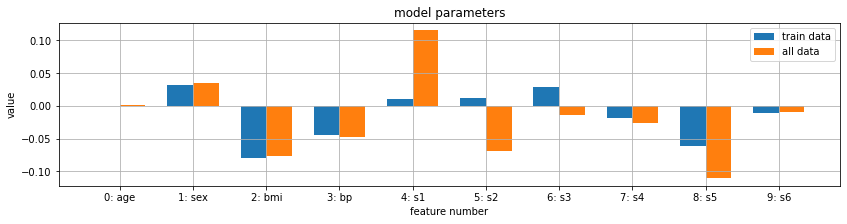

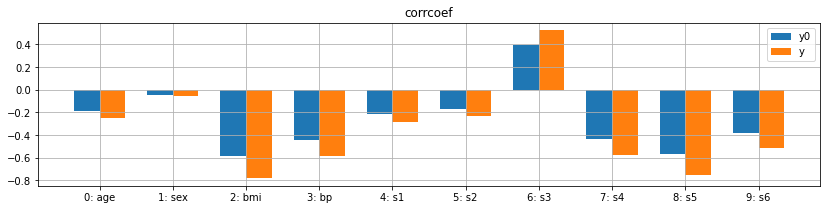

In [7]:
# baselines
verbose = True

# scikitlearn - to get optimal regularization coefficient via CV)
f_base_skl = RidgeCV(alphas=alphas, cv=None).fit(x_trn, y_trn)
w_base_skl = f_base_skl.coef_
best_alpha = float(f_base_skl.alpha_)
best_alpha_idx = int(np.where(alphas==best_alpha)[0])

# benchmark trained on all data
f_bench = RidgeCV(alphas=alphas, cv=None).fit(x, y)
w_bench = f_bench.coef_

# ours - for sanity check (vs SKL) and to get baseline improvement
f_base = pred.PredModel(d, reg_type=reg_type, alpha=best_alpha, lr=lr_f, num_iter_init=num_iter_base)
model_base = Lookahead(f_base, None, None, lam=0., eta=eta, mask=mask, ground_truth_model=fstar)
_, _ = model_base.train(x_trn, y_trn, num_cycles=0, random_state=seed, verbose=verbose)

plt.rcParams['figure.figsize'] = (14.0, 3.0)
barWidth = 0.35
plt.bar(np.arange(d)-barWidth/2,w_base_skl,alpha=1,width=barWidth)
plt.bar(np.arange(d)+barWidth/2,w_bench,alpha=1,width=barWidth)
plt.xticks(np.arange(d),titles_idx)
plt.title('model parameters')
plt.ylabel('value')
plt.xlabel('feature number')
plt.legend(['train data','all data'])
plt.grid()
plt.show()


cor_y0 = [np.corrcoef(x[:,i],y0)[0,1] for i in range(d)]
cor_y = [np.corrcoef(x[:,i],y)[0,1] for i in range(d)]
plt.bar(np.arange(d)-barWidth/2,cor_y0,width=barWidth)
plt.bar(np.arange(d)+barWidth/2,cor_y,width=barWidth)
plt.title('corrcoef')
plt.legend(['y0','y'])
plt.xticks(np.arange(d),titles_idx)
plt.grid()
plt.show()

perf_base_skl = {'mse':[], 'mae':[]}
for x_,y_ in zip(xs, ys):
    yhat_ = f_base_skl.predict(x_)
    perf_base_skl['mse'].append(np.mean(np.square(y_-yhat_)))
    perf_base_skl['mae'].append(np.mean(np.abs(y_-yhat_)))
print('baseline: (skl)')
print('\t\ttrn\ttst\tactv\tall')
print(('mse'+'\t{:.4f}'*4).format(*perf_base_skl['mse']))
print(('mae'+'\t{:.4f}'*4).format(*perf_base_skl['mae']))
print()

perf_base = {'mse':[], 'mae':[], 'improve':[], 'imprate':[]}
for x_,y_ in zip(xs, ys):
    perf_base['mse'].append(model_base.mse(x_,y_))
    perf_base['mae'].append(model_base.mae(x_,y_))
    perf_base['improve'].append(model_base.improve(x_,y_,eta,mask))
    perf_base['imprate'].append(model_base.improve_rate(x_,y_,eta,mask))
print('baseline: (ours)')
print('base:\ttrn\ttst\tactv\tall')
print(('mse'+'\t{:.4f}'*4).format(*perf_base['mse']))
print(('mae'+'\t{:.4f}'*4).format(*perf_base['mae']))
print(('imprv'+'\t{:.4f}'*4).format(*perf_base['improve']))
print(('imprt'+'\t{:.4f}'*4).format(*perf_base['imprate']))
print()

print('best reg coef:', best_alpha, ', idx:', best_alpha_idx)

## Training the lookahead model for different values of l2-regularizer coefficient

In [8]:
# train our model
verbose = True

#==TEMP==
# alphas_sub = [1e-7]
# lams = [0, 0.01, 0.05]
# num_cycles = 5
#========

all_models = []
all_mfs = []
all_mus = []
for alpha in alphas_sub:
    models = []
    mfs = []
    mus = []
    for lam_ in lams:
        print('-- alpha:', alpha, ', lam_:', lam_, '--')
        f = pred.PredModel(d, reg_type=reg_type, alpha=alpha, lr=lr_f, num_iter=num_iter_f, num_iter_init=num_iter_init)
        u = uncert.BootstrapResid(d, f, alpha=0., num_gs=num_gs, z_score=z_score, lr=lr_g, num_iter=num_iter_g)
        h = prop.PropModel(random_state=seed)

        model = Lookahead(f, u, h, lam=lam_, eta=eta, mask=mask, ground_truth_model=fstar)
        mf, mu = model.train(x_trn, y_trn, num_cycles=num_cycles, random_state=seed, verbose=verbose)

        models.append(model)
        mfs.append(mf)
        mus.append(mu)
    all_models.append(models)
    all_mfs.append(mfs)
    all_mus.append(mus)


all_mus = np.asarray(all_mus)
all_mfs = np.asarray(all_mfs)

-- alpha: 0 , lam_: 1e-05 --
t: 0
[f] mse: 0.0278, la_reg: 0.0000, norm_reg: 0.0000, obj: 0.0278
[f] improve*: 0.056

t: 1
[h] n_eff: 5.21, w_sum: 910.72
[u] loss: 0.0182, norm_reg: 0.0000, obj: 0.0182
[u] size: 0.402, contain*: 0.964
[f] mse: 0.0277, la_reg: 0.1769, norm_reg: 0.0000, obj: 0.0278
[f] improve*: 0.057

t: 2
[h] n_eff: 4.99, w_sum: 934.05
[u] loss: 0.0173, norm_reg: 0.0000, obj: 0.0173
[u] size: 0.414, contain*: 0.964
[f] mse: 0.0277, la_reg: 0.1819, norm_reg: 0.0000, obj: 0.0277
[f] improve*: 0.059

t: 3
[h] n_eff: 4.84, w_sum: 942.86
[u] loss: 0.0165, norm_reg: 0.0000, obj: 0.0165
[u] size: 0.423, contain*: 0.964
[f] mse: 0.0277, la_reg: 0.1855, norm_reg: 0.0000, obj: 0.0277
[f] improve*: 0.060

t: 4
[h] n_eff: 4.73, w_sum: 940.69
[u] loss: 0.0160, norm_reg: 0.0000, obj: 0.0160
[u] size: 0.430, contain*: 0.964
[f] mse: 0.0277, la_reg: 0.1880, norm_reg: 0.0000, obj: 0.0277
[f] improve*: 0.061

t: 5
[h] n_eff: 4.66, w_sum: 930.73
[u] loss: 0.0156, norm_reg: 0.0000, obj: 0

KeyboardInterrupt: 

## Evaluating the performance of the trained lookahead models

In [ ]:
# evaluate

all_perf_la = []
for i in range(len(alphas_sub)):
    perf_la = {'mse':[], 'mae':[], 'improve':[], 'imprate':[], 'contain':[], 'size':[]}
    for lam, model in zip(lams,all_models[i]):
        perf_la['mse'].append([model.mse(x_,y_) for x_,y_ in zip(xs,ys)])
        perf_la['mae'].append([model.mae(x_,y_) for x_,y_ in zip(xs,ys)])
        perf_la['improve'].append([model.improve(x_,y_,eta,mask) for x_,y_ in zip(xs,ys)])
        perf_la['imprate'].append([model.improve_rate(x_,y_,eta,mask) for x_,y_ in zip(xs,ys)])

        xsp = [model.move_points(x_) for x_ in xs]
        perf_la['contain'].append([model.contain(x_)[0] for x_ in [*xsp, x]])
        perf_la['size'].append([model.contain(x_)[1] for x_ in [*xsp, x]])
    perf_la = {k:np.asarray(v) for k,v in zip(perf_la.keys(),perf_la.values())}
    all_perf_la.append(perf_la)

print('lookahead: eta:', eta)
for j in range(len(alphas_sub)):
    for i in range(len(lams)):
        print('\n==============================================\n')
        print('alpha:', alphas_sub[j], 'lam:', lams[i])
        print('\ttrn\ttst\tactv\tall\tf*')
        print(('mse'+'\t{:.4f}'*5).format(*all_perf_la[j]['mse'][i,:], mse_star))
        print(('mae'+'\t{:.4f}'*5).format(*all_perf_la[j]['mae'][i,:], mae_star))
        print(('imprv'+'\t{:.4f}'*4).format(*all_perf_la[j]['improve'][i,:]))
        print(('imprt'+'\t{:.4f}'*4).format(*all_perf_la[j]['imprate'][i,:]))
        print()
        print('\ttrn\'\ttst\'\tactv\'\tall\'\tall')
        print(('contn'+'\t{:.3f}'*5).format(*all_perf_la[j]['contain'][i,:]))
        print(('intrsz'+'\t{:.3f}'*5).format(*all_perf_la[j]['size'][i,:]))


## Training the lookahead+CQR model for different values of l2-regularizer coefficient

In [ ]:
# train our model
verbose = True

#==TEMP==
# alphas_sub = [1e-7]
# lams = [0, 0.01, 0.05]
# num_cycles = 5
#========

all_cqr_models = []
all_cqr_mfs = []
all_cqr_mus = []
for alpha in alphas_sub:
    cqr_models = []
    cqr_mfs = []
    cqr_mus = []
    for lam_ in lams:
        print('-- alpha:', alpha, ', lam_:', lam_, '--')
        f = pred.PredModel(d, reg_type=reg_type, alpha=alpha, lr=lr_f, num_iter=num_iter_f, num_iter_init=num_iter_init)
        u = CQR(d, tau=(0.05, 0.95), lr=0.001, num_iter=5000)
        h = prop.PropModel(random_state=seed)

        model = Lookahead(f, u, h, lam=lam_, eta=eta, mask=mask, ground_truth_model=fstar)
        mf, mu = model.train(x_trn, y_trn, num_cycles=num_cycles, random_state=seed, verbose=verbose)

        cqr_models.append(model)
        cqr_mfs.append(mf)
        cqr_mus.append(mu)

    all_cqr_models.append(cqr_models)
    all_cqr_mfs.append(cqr_mfs)
    all_cqr_mus.append(cqr_mus)


all_cqr_mus = np.asarray(all_cqr_mus)
all_cqr_mfs = np.asarray(all_cqr_mfs)

## Evaluating the performance of the trained lookahead+CQR models

In [ ]:
# evaluate

all_cqr_perf_la = []
for i in range(len(alphas_sub)):
    perf_cqr_la = {'mse':[], 'mae':[], 'improve':[], 'imprate':[], 'contain':[], 'size':[]}
    for lam, model in zip(lams,all_cqr_models[i]):
        perf_cqr_la['mse'].append([model.mse(x_,y_) for x_,y_ in zip(xs,ys)])
        perf_cqr_la['mae'].append([model.mae(x_,y_) for x_,y_ in zip(xs,ys)])
        perf_cqr_la['improve'].append([model.improve(x_,y_,eta,mask) for x_,y_ in zip(xs,ys)])
        perf_cqr_la['imprate'].append([model.improve_rate(x_,y_,eta,mask) for x_,y_ in zip(xs,ys)])

        xsp = [model.move_points(x_) for x_ in xs]
        perf_cqr_la['contain'].append([model.contain(x_)[0] for x_ in [*xsp, x]])
        perf_cqr_la['size'].append([model.contain(x_)[1] for x_ in [*xsp, x]])
    perf_cqr_la = {k:np.asarray(v) for k,v in zip(perf_cqr_la.keys(),perf_cqr_la.values())}
    all_cqr_perf_la.append(perf_cqr_la)

print('lookahead: eta:', eta)
for j in range(len(alphas_sub)):
    for i in range(len(lams)):
        print('\n==============================================\n')
        print('alpha:', alphas_sub[j], 'lam:', lams[i])
        print('\ttrn\ttst\tactv\tall\tf*')
        print(('mse'+'\t{:.4f}'*5).format(*all_cqr_perf_la[j]['mse'][i,:], mse_star))
        print(('mae'+'\t{:.4f}'*5).format(*all_cqr_perf_la[j]['mae'][i,:], mae_star))
        print(('imprv'+'\t{:.4f}'*4).format(*all_cqr_perf_la[j]['improve'][i,:]))
        print(('imprt'+'\t{:.4f}'*4).format(*all_cqr_perf_la[j]['imprate'][i,:]))
        print()
        print('\ttrn\'\ttst\'\tactv\'\tall\'\tall')
        print(('contn'+'\t{:.3f}'*5).format(*all_cqr_perf_la[j]['contain'][i,:]))
        print(('intrsz'+'\t{:.3f}'*5).format(*all_cqr_perf_la[j]['size'][i,:]))


## Train a baseline model on different values of l2 regularizer and naive model for different scales

In [ ]:
verbose = True

models_base = []
for alpha in alphas:
    f_base = pred.PredModel(d, reg_type=reg_type, alpha=alpha, lr=lr_f, num_iter_init=num_iter_base)
    model_base = Lookahead(f_base, None, None, lam=0., eta=eta, mask=mask, ground_truth_model=fstar)
    _, _ = model_base.train(x_trn, y_trn, num_cycles=0, random_state=seed, verbose=verbose)
    models_base.append(model_base)

perf_base = {'mse':[], 'mae':[], 'improve':[], 'imprate':[]} #, 'contain':[], 'size':[]}
for model in models_base:
    perf_base['mse'].append([model.mse(x_,y_) for x_,y_ in zip(xs,ys)])
    perf_base['mae'].append([model.mae(x_,y_) for x_,y_ in zip(xs,ys)])
    perf_base['improve'].append([model.improve(x_,y_,eta,mask) for x_,y_ in zip(xs,ys)])
    perf_base['imprate'].append([model.improve_rate(x_,y_,eta,mask) for x_,y_ in zip(xs,ys)])
perf_base = {k:np.asarray(v) for k,v in zip(perf_base.keys(),perf_base.values())}

In [ ]:
for i in range(len(alphas)):
    print('\n==============================================\n')
    print('alpha:', alphas[i])
    print('\ttrn\ttst\tactv\tall\tf*')
    print(('mse'+'\t{:.4f}'*5).format(*perf_base['mse'][i,:], mse_star))
    print(('mae'+'\t{:.4f}'*5).format(*perf_base['mae'][i,:], mae_star))
    print(('imprv'+'\t{:.4f}'*4).format(*perf_base['improve'][i,:]))
    print(('imprt'+'\t{:.4f}'*4).format(*perf_base['imprate'][i,:]))
    print()

## Plots

In [ ]:
from scipy.interpolate import griddata
from scipy.ndimage.filters import gaussian_filter

feats = [2,4]
m_idx = -1

model = models[m_idx]
w_f = model.f.model.linear.weight.detach().numpy().squeeze()

cqr_model = cqr_models[m_idx]
w_f_cqr = cqr_model.f.model.linear.weight.detach().numpy().squeeze()


ngridx = 100
ngridy = 100
x1i = np.linspace(-2.5, 4, ngridx)
x2i = np.linspace(-3, 3.8, ngridy)

xp = model.move_points(x,eta,mask)
xp_trn, xp_tst = xp[idx_trn,:], xp[idx_tst,:]
xp1 = xp[:,feats[0]]
xp2 = xp[:,feats[1]]
lb, ub = model.u.predict(xp)
sz = ub-lb

# plt.scatter(x1,sz)
# plt.scatter(x2,sz)
# plt.show()

szi = griddata((xp1, xp2), sz, (x1i[None,:], x2i[:,None]), method='linear')
# szi = gaussian_filter(szi, 0.7)

n_ = 20
plt.rcParams['figure.figsize'] = (12.0, 12.0)
plt.contourf(x1i, x2i, szi, levels=10, alpha=0.5) #, linewidths=0.5, colors='k')
for i in range(n_):
    plt.plot([x_tst[i,feats[0]],xp_tst[i,feats[0]]],[x_tst[i,feats[1]],xp_tst[i,feats[1]]],'k')

plt.scatter(x_tst[:n_,feats[0]], x_tst[:n_,feats[1]], color='k', s=12) #,markerfacecolor=None)
plt.scatter(xp_tst[:n_,feats[0]], xp_tst[:n_,feats[1]], color='r', s=12) #,markerfacecolor=None)
plt.colorbar()
plt.xlabel(titles_idx[feats[0]])
plt.ylabel(titles_idx[feats[1]])
plt.show()

In [ ]:
from scipy.interpolate import griddata
from scipy.ndimage.filters import gaussian_filter

feats = [2,4]

ngridx = 100
ngridy = 100
x1i = np.linspace(-1.9, 3.6, ngridx)
x2i = np.linspace(-2.7, 3.3, ngridy)

x1 = x[:,feats[0]]
x2 = x[:,feats[1]]

yi = griddata((x1, x2), y, (x1i[None,:], x2i[:,None]), method='linear')
yi = gaussian_filter(yi, 0.7)

n_ = 20
plt.rcParams['figure.figsize'] = (8.0, 8.0)
plt.contourf(x1i, x2i, yi, levels=5, alpha=0.5) #, linewidths=0.5, colors='k')
for i in range(n_):
    plt.plot([x_tst[i,feats[0]],xp_tst[i,feats[0]]],[x_tst[i,feats[1]],xp_tst[i,feats[1]]],'k')

plt.scatter(x_tst[:n_,feats[0]], x_tst[:n_,feats[1]], color='k', s=12) #,markerfacecolor=None)
plt.scatter(xp_tst[:n_,feats[0]], xp_tst[:n_,feats[1]], color='r', s=12) #,markerfacecolor=None)
plt.colorbar()
plt.xlabel(titles_idx[feats[0]])
plt.ylabel(titles_idx[feats[1]])
plt.show()

In [ ]:
plt.plot(perf_base['imprate'][:,1],'-x')
plt.plot(all_perf_la[0]['imprate'][:,1],'-x')
plt.plot(all_cqr_perf_la[0]['imprate'][:,1],'-x')

In [ ]:
# plot
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

SAVE_FIG = False
fname = 'diabetes_mask_2-4_v2'

plt.rcParams['figure.figsize'] = (6.0, 4.0)
plt.rcParams['axes.prop_cycle'] = cycler.cycler('color', plt.cm.tab20(np.arange(0,22,2)))
alphas_idx = [0, 4, -2]

print('seed:',seed,', eta:',eta)
plt.plot(perf_base['improve'][:,0], np.sqrt(perf_base['mse'][:,0]),'b-x')
for i in alphas_idx:
    plt.plot(all_perf_la[i]['improve'][:,0], np.sqrt(all_perf_la[i]['mse'][:,0]),'r-x')

for i in alphas_idx:
    plt.plot(all_cqr_perf_la[i]['improve'][:,0], np.sqrt(all_perf_la[i]['mse'][:,0]),'r-x')

# plt.plot(perf_naive['improve'][:,0], perf_naive['mse'][:,0],'g-x')
plt.title('frontier - train')
plt.ylabel('mse')
plt.xlabel('improve')
plt.legend([r'baseline (varying $\alpha$)','la (lambda)', 'la+cqr (lambda)'])
plt.grid()
# plt.ylim([0.,0.18])
plt.show()


plt.plot(perf_base['improve'][:,1], np.sqrt(perf_base['mse'][:,1]),'-o',markerfacecolor=None,c='purple')
for i in alphas_idx:
    plt.plot(all_perf_la[i]['improve'][:,1], np.sqrt(all_perf_la[i]['mse'][:,1]),'-o',markerfacecolor='white')

for i in alphas_idx:
    plt.plot(all_cqr_perf_la[i]['improve'][:,1], np.sqrt(all_perf_la[i]['mse'][:,1]),'-o',markerfacecolor='white')

# plt.plot(perf_naive['improve'][:,1], perf_naive['mse'][:,1],'g-x')
plt.title('accuracy-improvement frontier (partial mutability)')
plt.ylabel('RMSE [$(y-\hat{y})^2$]')
plt.xlabel('average improvement [$y\'-y$]')
plt.legend(
    [
        r'baseline ($\lambda$=0, varying $\alpha$)',
        *[r'lookahead (varying $\lambda$, $\alpha={}$)'.format(alphas_sub[i]) for i in alphas_idx],
        *[r'lookahead+cqr (varying $\lambda$, $\alpha={}$)'.format(alphas_sub[i]) for i in alphas_idx],
    ],
    loc='upper left',
)
plt.grid()
plt.ylim([0.165, 0.175])
plt.xlim([0.035,0.22])

xx = perf_base['improve'][0,1]
yy = np.sqrt(perf_base['mse'][0,1])
plt.annotate(r'$\alpha$',
ha = 'center', va = 'bottom',
xytext = (xx-0.01,yy+0.001),
xy = (xx-0.03, yy+0.0017),
arrowprops = { 'facecolor' : 'black', 'shrink' : 0.05 , 'width':0.5, 'headwidth':7, 'headlength':7},
fontsize=11)
plt.annotate(r'$\lambda$',
ha = 'center', va = 'bottom',
xytext = (xx+0.008,yy+0.001),
xy = (xx+0.03, yy+0.0017),
arrowprops = { 'facecolor' : 'black', 'shrink' : 0.05 , 'width':0.5, 'headwidth':7, 'headlength':7},
fontsize=11)

ax = plt.gca()
axins = inset_axes(ax, width="25%", height="25%", loc=4)
axins.plot(np.linspace(0,1,len(alphas)),perf_base['imprate'][:,1],'-o',markerfacecolor=None,c='purple',markersize=3)
for i in alphas_idx:
    axins.plot(np.linspace(0,1,len(lams)),all_perf_la[i]['imprate'][:,1],'-o',markerfacecolor='white',markersize=3)
    axins.plot(np.linspace(0,1,len(lams)),all_cqr_perf_la[i]['imprate'][:,1],'-o',markerfacecolor='white',markersize=3)

axins.set_xticks([])
axins.set_yticks([0.5,0.75, 1.0])
axins.yaxis.tick_right()
axins.set_xlim([0,1])
axins.set_ylabel('imp. rate')


plt.rcParams['axes.prop_cycle'] = cycler.cycler('color', plt.cm.tab10(np.arange(10)))

if SAVE_FIG:
    plt.draw()
    plt.savefig(fname+'.eps', format='eps', bbox_inches='tight')
    plt.savefig(fname+'.png', format='png', dpi=300, bbox_inches='tight')
    print('saved ' + fname)
else:
    plt.show()

In [ ]:
SAVE_FIG = False
# fname = 'wine_mask_ws'


models = all_models[0] #has alpha=0
cqr_models = all_cqr_models[0] #has alpha=0

ws_la_cqr = np.asarray([m.f.model.linear.weight.detach().numpy().squeeze() for m in cqr_models])
ws_la = np.asarray([m.f.model.linear.weight.detach().numpy().squeeze() for m in models])
ws_base = np.asarray([m.f.model.linear.weight.detach().numpy().squeeze() for m in models_base])

mask_idx = np.where(mask>0)[0]
non_mask_idx = np.setdiff1d(np.arange(d), mask_idx)

plt.rcParams['figure.figsize'] = (5.0, 4.0)
plt.rcParams['axes.prop_cycle'] = cycler.cycler('color', plt.cm.tab20(np.arange(1,22,2)))
for i in range(d):
    if i not in list(mask_idx):
        plt.plot(np.arange(len(lams)),ws_la[:,i],'-') #,alpha=a)

    else:
        plt.plot([],[])

plt.gca().set_prop_cycle(cycler.cycler('color', plt.cm.tab20(np.arange(0,22,2))))
for i in range(d):
    if i in list(mask_idx):
        plt.plot(np.arange(len(lams)),ws_la[:,i],'-x') #,alpha=a)

    else:
        plt.plot([],[])

for i in range(d):
    if i not in list(mask_idx):
        plt.plot(np.arange(len(lams)),ws_la_cqr[:,i],'-') #,alpha=a)

    else:
        plt.plot([],[])

plt.gca().set_prop_cycle(cycler.cycler('color', plt.cm.tab20(np.arange(0,22,2))))
for i in range(d):
    if i in list(mask_idx):
        plt.plot(np.arange(len(lams)),ws_la_cqr[:,i],'-x') #,alpha=a)

    else:
        plt.plot([],[])

plt.gca().set_prop_cycle(cycler.cycler('color', plt.cm.tab20(np.arange(1,22,2))))
plt.plot(np.arange(0,-len(alphas),-1)/2,ws_base,'-.') #alpha=0.5)

plt.gca().set_prop_cycle(None)
for i in range(len(w_bench)):
    plt.plot(0,ws_base[0,i],'o',markerfacecolor='white')

plt.grid()
plt.ylim([-0.4,0.36])
plt.xlim([-6,6])
plt.title('coefficients of $f$ (partial mutability)')
plt.ylabel('coeff. value (one line per feature)')
plt.xlabel(r'$\leftarrow \alpha \qquad \qquad \lambda \rightarrow$')
plt.xticks([-6,-4,-2,0,2,4,6], [16,0.5,0.03,0,0.125,0.5,2])

custom_lines = [
    Line2D([0], [0], ls='-', marker='x', color='g', lw=1),
    Line2D([0], [0], ls='-', color='g', lw=1),
    Line2D([0], [0], ls='-', marker='o', color='b', lw=1),
    Line2D([0], [0], ls='-', color='b', lw=1),
    Line2D([0], [0], ls='-.', color='k', lw=1),
]

plt.legend(
    custom_lines,
    [
        'lookahead (mutable)',
        'lookahead (immutable)',
        'lookahead+cqr (mutable)',
        'lookahead+cqr (immutable)',
        'baseline',
    ],
    loc='upper left',
    fontsize=9.5)
plt.legend(titles_idx)

if SAVE_FIG:
    plt.draw()
    plt.savefig(fname+'.eps', format='eps', bbox_inches='tight')
    plt.savefig(fname+'.png', format='png', dpi=300, bbox_inches='tight')
    print('saved ' + fname)
else:
    plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = (16.0, 5.0)

plt.subplot(121)
plt.plot(np.arange(len(lams)), perf_la['contain'][:,:2],'x-')
plt.title('la coverage rate')
plt.ylabel('coverage rate')
plt.xlabel('lambda')
plt.xticks(np.arange(len(lams)),lams)
plt.legend(['train','test'])

plt.subplot(122)
plt.plot(np.arange(len(lams)), perf_la['size'][:,:2],'x-')
plt.title('la interval size')
plt.ylabel('interval size')
plt.xlabel('lambda')
plt.xticks(np.arange(len(lams)),lams)
plt.legend(['train','test'])
plt.show()

plt.subplot(121)
plt.plot(np.arange(len(lams)), perf_cqr_la['contain'][:,:2],'x-')
plt.title('la+cqr coverage rate')
plt.ylabel('coverage rate')
plt.xlabel('lambda')
plt.xticks(np.arange(len(lams)),lams)
plt.legend(['train','test'])

plt.subplot(122)
plt.plot(np.arange(len(lams)), perf_cqr_la['size'][:,:2],'x-')
plt.title('la+cqr interval size')
plt.ylabel('interval size')
plt.xlabel('lambda')
plt.xticks(np.arange(len(lams)),lams)
plt.legend(['train','test'])
plt.show()